# Definitions

## Parameters

In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime as dt
import os
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

ROOT_DIR = os.path.dirname(os.path.abspath("__file__"))
PARENT_DIR = os.path.dirname(ROOT_DIR)

from scrapers.ap import AP_DIR
from scrapers.fox import FOX_DIR
from scrapers.cnn import CNN_DIR
from scrapers.abc import ABC_DIR
from scrapers.cbs import CBS_DIR
from scrapers.nyt import NYT_DIR
from scrapers.mirror import MIRROR_DIR
from scrapers.reuters import REUTERS_DIR
from scrapers.express import EXPRESS_DIR
from scrapers.huffpost import HUFFPOST_DIR
from scrapers.guardian import GUARDIAN_DIR
from scrapers.dailymail import DAILYMAIL_DIR


In [2]:
# matplotlib globals
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 13
mpl.rcParams["xtick.labelsize"] = 13
mpl.rcParams["ytick.labelsize"] = 13
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = "medium"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

# mpl.rcParams.keys()


In [3]:
centininch = 2.54
inchincent = 0.3937


def centtoinch(cents):
    return 0.3937 * cents


def inchtocent(inches):
    return 2.54 * inches


## Data

In [4]:
dirs = [i for i in globals().values() if str(i).endswith(".csv")]
source, data, davg, ntr, dcount = [], [], [], [], []
for i in dirs:
    name = str(re.sub(r"^(.*?)data\/", "", i[:-4]))
    source.append(name)
    data_df = pd.read_csv(os.path.join(ROOT_DIR, "results", name + "_Results.csv"), parse_dates=["Date"], index_col=["Date"])
    data.append(data_df)
    davg_df = data_df.drop(columns=["Title", "Text", "URL", "Topic"]).resample("D").mean()
    davg.append(davg_df)
    ntr.append(pd.read_table(os.path.join(ROOT_DIR, "results", name + "_NovelTransReson.txt"), sep=" ", header=None, names=["Novelty", "Transience", "Resonance"]))
    dcount_df = data_df.resample("D").apply({"URL": "count"})
    dcount.append(dcount_df)


## Line Plots

In [5]:
def line_plot_resonance(data, title, xlabel="", ylabel=""):

    fig, ax = plt.subplots(figsize=(25, 2.5))

    ax.locator_params(axis="x", nbins=12)
    beginning = dt.date(2021, 11, 1)
    end = dt.date.today()

    ax.plot(
        data.index.values,
        data["Resonance"],
        color="black",
        linewidth=1,
    )

    ax.vlines(x=["2022-03-01", "2022-08-01"], ymin=-2.5, ymax=2.5, color="k", linewidth=1.5, linestyle=":")

    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        title=title,
        xbound=(beginning, end),
        ylim=[-2.5, 2.5001],
    )

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 2.5))

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")


def multi_line_plot_resonance(list, title):

    color_list = ["red", "lawngreen", "gold", "dodgerblue", "blueviolet", "magenta", "slategray", "black", "midnightblue", "darkgreen", "saddlebrown", "lightcoral"]
    fig, ax = plt.subplots(figsize=(25, 2.5))

    ax.locator_params(axis="x", nbins=12)
    beginning = dt.date(2021, 11, 1)
    end = dt.date.today()

    for data, color in zip(list, color_list):
        ax.plot(
            data.index.values,
            data["Resonance"],
            color="black",
            linewidth=1,
            alpha=0.3,
        )

    ax.vlines(x=["2022-03-01", "2022-08-01"], ymin=-2.5, ymax=2.5, color="k", linewidth=1.5, linestyle=":")

    ax.set(
        title=title,
        xbound=(beginning, end),
        ylim=[-2.5, 2.5001],
    )

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 2.5))

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")


def line_plot_count(data, title, xlabel="", ylabel=""):

    fig, ax = plt.subplots(figsize=(25, 2.5))
    fig.canvas.draw()

    ax.locator_params(axis="x", nbins=12)
    beginning = dt.date(2021, 11, 1)
    end = dt.date.today()

    ax.plot(
        data.index.values,
        data["URL"],
        color="black",
        linewidth=1,
    )

    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        title=title,
        xbound=(beginning, end),
    )

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, end / 5))

    ticksx = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticksx[0].set_horizontalalignment("left")

    ticksy = ["{i:.0f}".format(i=item) for item in ax.get_yticks()]
    ticksy[0] = "0"
    ax.set_yticklabels(ticksy)


## Density plots

In [6]:
def plot_quants_2Dhist(quants, DATA_NTR, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=False, cbar_orientation="vertical", colorvmax=None):

    q0 = DATA_NTR[quants[0]]  # ["Novelty", "Resonance"][0]
    q1 = DATA_NTR[quants[1]]

    q0bins = xbins
    q1bins = ybins

    H, xedges, yedges = np.histogram2d(q0.to_numpy(), q1.to_numpy(), bins=[q0bins, q1bins])

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)

    # Mask zeros
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value

    # Plot 2D histogram using pcolor
    if colorvmax:
        usemax = colorvmax
    else:
        usemax = H.max()
    pcolm = ax.pcolormesh(xedges, yedges, Hmasked, norm=mpl.colors.LogNorm(vmin=1, vmax=usemax))

    if make_cbar:
        if cbar_axis:
            cbar = fig.colorbar(pcolm, cax=cbar_axis, orientation=cbar_orientation)
        else:
            cbar = fig.colorbar(pcolm, ax=ax, orientation=cbar_orientation)
        cbar.ax.set_ylabel("counts")

    ax.set_xlabel(quants[0])
    ax.set_ylabel(quants[1])

    if make_cbar:
        return H, cbar
    else:
        return H


In [7]:
def tvn_plot(source, name, n):

    fig = plt.figure(figsize=(4.5, 2.5))

    ########################################################## Plot Transience v. Novelty ##########################################################

    # Formato Eixos
    ax = fig.add_axes([0, 0.19, 0.4, 0.72])  # Dist do Y, Dist do X, largura, altura do grafico

    # Formato Cbar
    cbaxes = fig.add_axes([0.4, 0.29, 0.025, 0.5])  # Dist do Y, Dist do X, largura, altura da cbar

    # Colunas
    quants = ["Novelty", "Transience"]

    # Quadrados (bins)
    xbins = np.linspace(0, 10, 30)
    ybins = np.linspace(0, 10, 30)

    ## Gerando gráfico
    H, cbar = plot_quants_2Dhist(quants, source, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=cbaxes, cbar_orientation="vertical")

    # Titulo
    ax.set_title(f"{name}\nTransience v. Novelty\n(n = {n})", x=0.5, y=1)

    # Colorbar
    cbar.ax.set_ylabel("")  # Sem label no Y
    cbar.ax.set_xlabel("")  # Sem label no X
    cbar.ax.yaxis.set_ticks_position("right")  # Posicaoo ticks
    cbar.ax.tick_params(labelsize=10)

    # Linha X=Y
    ax.plot([0, 10], [0, 10], color="k", linewidth=1.5, linestyle=":")

    # Legenda
    # ax.legend([mpl.lines.Line2D([0], [0], color="k", linewidth=1.5, linestyle="--")], ["x=y"], loc="upper center", fontsize=8, ncol=2, handlelength=2.7)

    # Eixo X
    ax.set_xlabel("Novelty $\mathcal{N}$")
    ax.set_xlim(0, 11.5)  # Escala do eixo X
    ax.set_xticks([0, 2, 4, 6, 8, 10])  # Numeros de interesse eixo
    ax.xaxis.set_ticks_position("bottom")  # Ticks embaixo
    ax.spines["bottom"].set_bounds(0, 10)  # Delimita eixo
    ax.spines["top"].set_visible(False)  # Oculta eixo superior

    # Eixo Y
    ax.set_ylabel("Transience $\mathcal{T}$")
    ax.set_ylim(0, 11.5)  # Escala do eixo Y
    ax.set_yticks([0, 2, 4, 6, 8, 10])  # Numeros de interesse eixo
    ax.yaxis.set_ticks_position("left")  # Ticks na esquerda
    ax.spines["left"].set_bounds(0, 10)  # Delimita eixo
    ax.spines["right"].set_visible(False)  # Oculta eixo direito
    ax.tick_params(labelsize=11)

    ########################################################## Plot Resonance v. Novelty ##########################################################

    # Formato Eixos
    ax = fig.add_axes([0.7, 0.19, 0.35, 0.65])  # Dist do Y, Dist do X, largura, altura do grafico

    # Formato Cbar
    cbaxes = fig.add_axes([1.1, 0.29, 0.025, 0.5])  # Dist do Y, Dist do X, largura, altura da cbar

    # Colunas
    quants = ["Novelty", "Resonance"]

    # Quadrados (bins)
    xbins = np.linspace(0, 11, 30)  # Range dos quadrados em X, larguras
    ybins = np.linspace(-7, 8, 30)  # Range dos quadrados em Y, alturas

    ## Gerando gráfico
    H, cbar = plot_quants_2Dhist(quants, source, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=cbaxes, cbar_orientation="vertical")

    # Titulo
    ax.set_title(f"{name}\nResonance v. Novelty\n(n = {n})", x=0.5, y=1.1)

    # Linha pontilhada
    ax.axhline(color="k", linewidth=1.5, linestyle=":")

    # Colorbar
    cbar.ax.set_ylabel("")  # Sem label no Y
    cbar.ax.set_xlabel("")  # Sem label no X
    cbar.ax.yaxis.set_ticks_position("right")  # Posicao ticks
    cbar.ax.tick_params(labelsize=10)  # Tamanho numeros ticks

    # Eixo X
    ax.set_xlabel("Novelty $\mathcal{N}$")
    ax.set_xlim(-1, 10)  # Escala do eixo X
    ax.set_xticks([0, 2, 4, 6, 8, 10])  # Numeros de interesse eixo
    ax.xaxis.set_ticks_position("bottom")  # Ticks embaixo
    ax.spines["bottom"].set_bounds(0, 10)  # Delimita eixo
    ax.spines["top"].set_visible(False)  # Oculta eixo superior

    # Eixo Y
    ax.set_ylabel("Resonance $\mathcal{R}}$")
    ax.set_ylim(-7, 8)  # Escala do eixo Y
    ax.set_yticks([-6, -3, 0, 3, 6])  # Numeros de interesse eixo
    ax.yaxis.set_ticks_position("left")  # Ticks na esquerda
    ax.spines["left"].set_bounds(-6, 6)  # Delimita eixo
    ax.spines["right"].set_visible(False)  # Oculta eixo direito
    ax.tick_params(labelsize=11)

    return fig


## Scatter Plots

In [8]:
def scatter_resonance(dirs,date_start,date_end):
    avg_novelties, avg_resonances,names = [],[],[]
    
    for name in dirs:
        name = str(re.sub(r"^(.*?)data\/", "", name[:-4]))
        names.append(name)
        i = pd.read_csv(os.path.join(ROOT_DIR, "results", name + "_Results.csv"))
        i['Date'] = pd.to_datetime(i['Date'])
        df_split = i.loc[(i['Date'] >= date_start) & (i['Date'] < date_end)]
        novelty = df_split["Novelty"].to_list()
        resonance = df_split["Resonance"].to_list()
        avg_novelties.append(sum(novelty)/len(novelty))
        avg_resonances.append(sum(resonance)/len(resonance))

    avg_novelty = sum(avg_novelties)/len(avg_novelties)
    avg_resonance = sum(avg_resonances)/len(avg_resonances)

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)

    plt.scatter(avg_resonances,avg_novelties,marker=".",color='black')
    min_resonance, max_resonance = ax.get_xlim()
    min_novelty, max_novelty = ax.get_ylim()

    plt.plot([min_resonance,2*avg_resonance-min_resonance],[avg_novelty,avg_novelty],'k', linestyle = ":", lw=1)
    plt.plot([avg_resonance,avg_resonance],[min_novelty,2*avg_novelty-min_novelty],'k', linestyle = ":", lw=1)

    
    ax.set_title("Novelty X Resonance - Averages")
    ax.set_xlabel("Resonance")
    ax.set_ylabel("Novelty")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for i, txt in enumerate(names):
        ax.annotate(txt, (avg_resonances[i]+0.0005, avg_novelties[i]-0.05))

    return fig


## Violin Plots

In [83]:
def violin(cmap,metric,dirs,date_start,date_end):
    from mycolorpy import colorlist as mcp

    def set_axis_style(ax, labels):
        ax.get_yaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_yticks(np.arange(1, len(labels) + 1))
        ax.set_yticklabels(labels)
        ax.set_ylim(0.25, len(labels) + 0.75)

    novelties,resonances = [],[]
    avg_novelties, avg_resonances,names = [],[],[]
    
    for name in dirs:
        name = str(re.sub(r"^(.*?)data\/", "", name[:-4]))
        names.append(name)
        i = pd.read_csv(os.path.join(ROOT_DIR, "results", name + "_Results.csv"))
        i['Date'] = pd.to_datetime(i['Date'])
        df_split = i.loc[(i['Date'] >= date_start) & (i['Date'] < date_end)]
        novelty = df_split["Novelty"].to_list()
        novelties.append(novelty)
        resonance = df_split["Resonance"].to_list()
        resonances.append(resonance)
        avg_novelties.append(sum(novelty)/len(novelty))
        avg_resonances.append(sum(resonance)/len(resonance))

    avg_novelty = sum(avg_novelties)/len(avg_novelties)
    avg_resonance = sum(avg_resonances)/len(avg_resonances)

    df = pd.DataFrame(list(zip(names, novelties, resonances, avg_novelties, avg_resonances)), columns =['Name', 'Novelty','Resonance','Avg_Novelty','Avg_Resonance'])
    df_sorted = df.sort_values(by="Avg_"+str(metric))

    fs = 10  # fontsize
    data = novelties

    fig, ax = plt.subplots(figsize=(6, 10))

    plot = ax.violinplot(df_sorted[metric], points=200, vert=False, widths=0.8,
                        showmeans=True, showextrema=True, showmedians=False,
                        bw_method=0.5)
    ax.set_title(str(metric))

    set_axis_style(ax, df_sorted["Name"])

    colors=mcp.gen_color(cmap,n=12)
    for i, pc in enumerate(plot["bodies"], 1):
            pc.set_linewidth(0.1)
            pc.set_edgecolor('black')
            pc.set_alpha(0.6)
            pc.set_facecolor(colors[i-1])

    w=1
    plot["cmeans"].set_color('#303030')
    plot["cmins"].set_color('#3d3d3d')
    plot["cmaxes"].set_color('#3d3d3d')
    plot["cbars"].set_color('#3d3d3d')
    plot["cmeans"].set_linewidth(1.3)
    plot["cmins"].set_linewidth(w)
    plot["cmaxes"].set_linewidth(w)
    plot["cbars"].set_linewidth(w)
    
    
    plt.show()

    return fig


# Plots

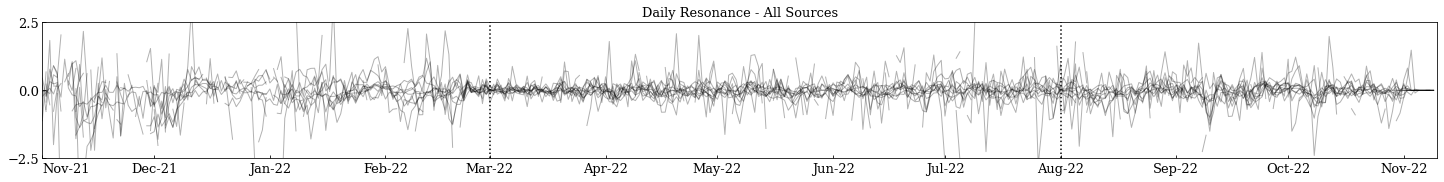

In [10]:
multi_line_plot_resonance(davg, "Daily Resonance - All Sources")


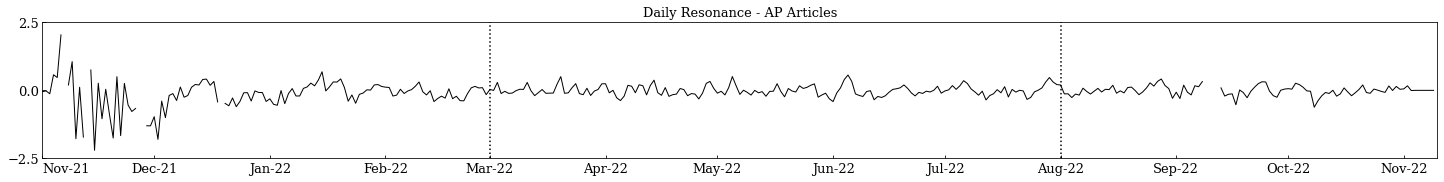

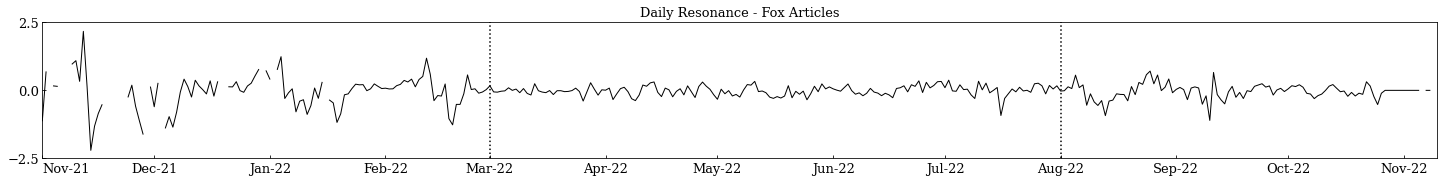

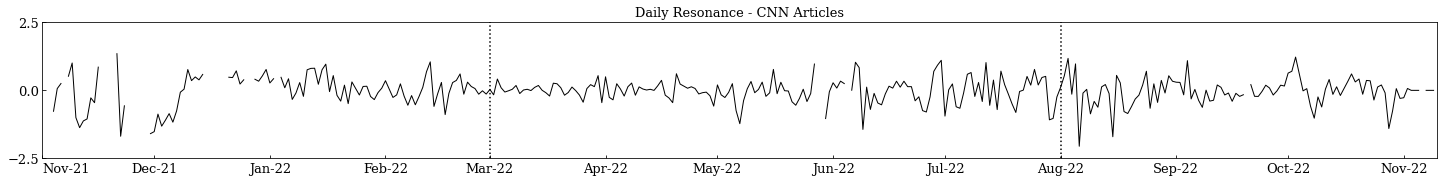

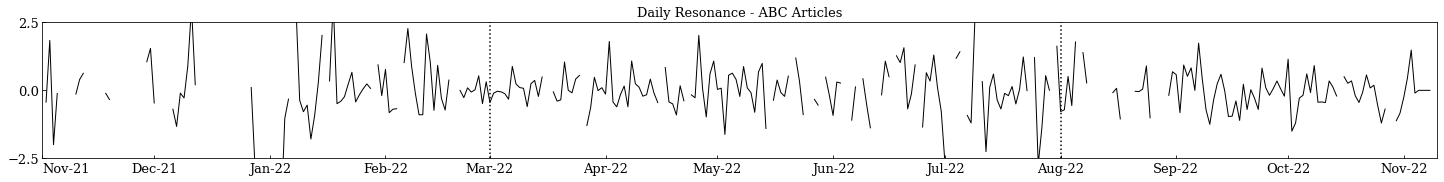

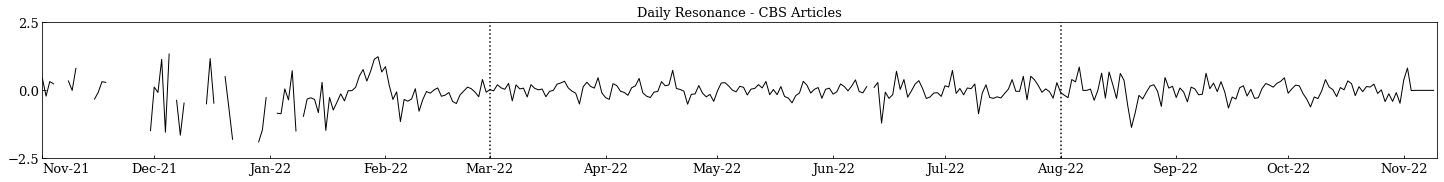

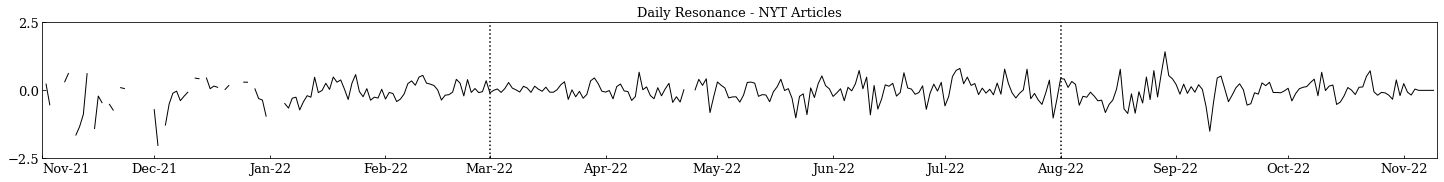

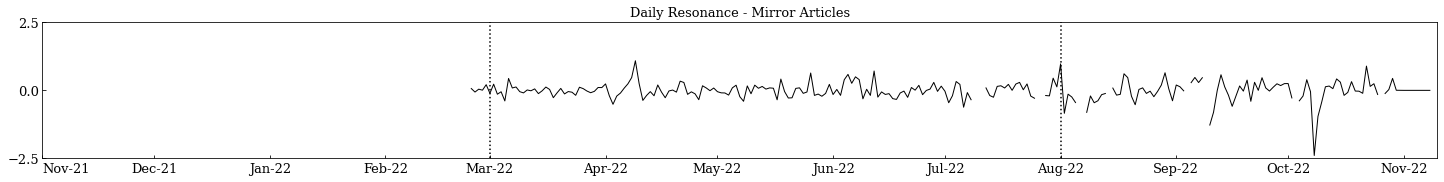

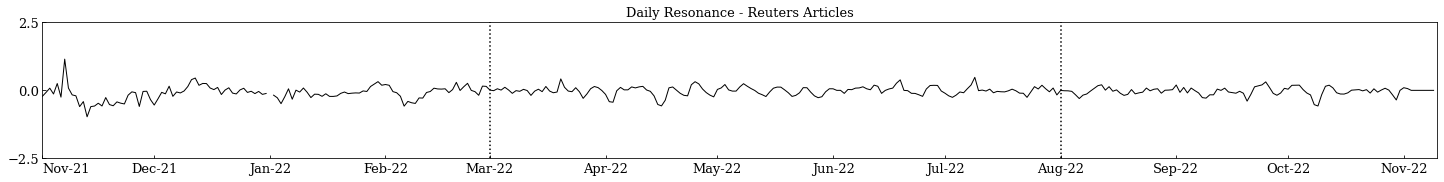

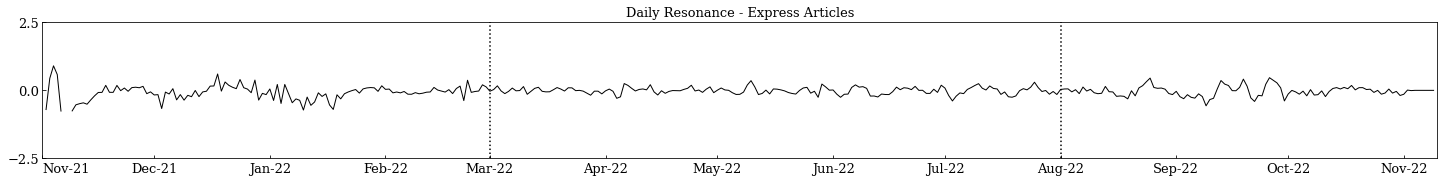

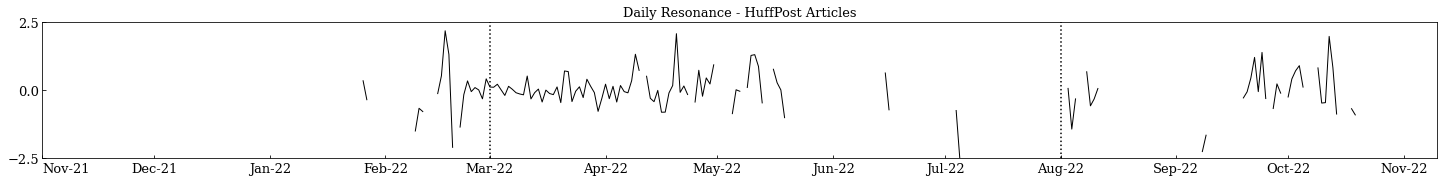

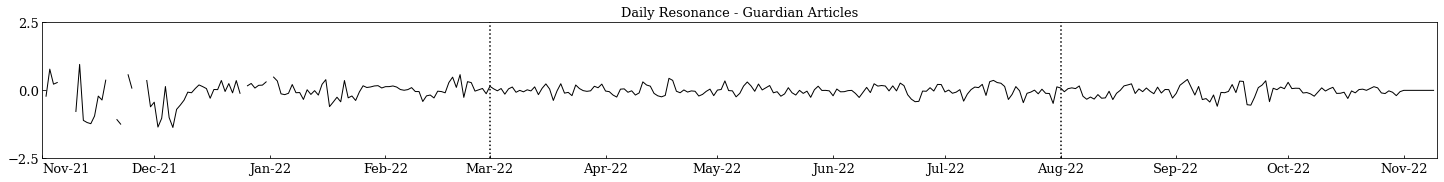

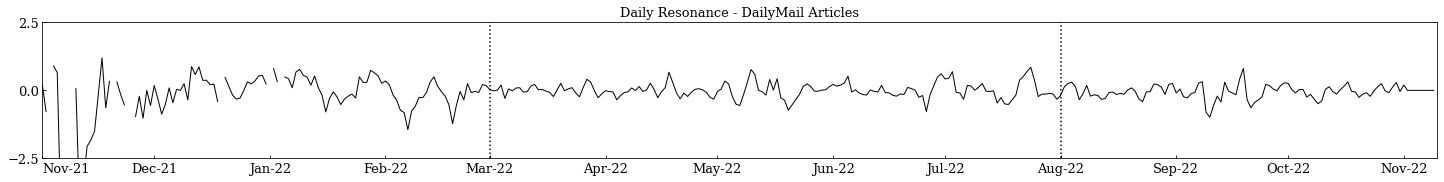

In [11]:
for i in range(0, len(source)):
    line_plot_resonance(davg[i], f"Daily Resonance - {source[i]} Articles")


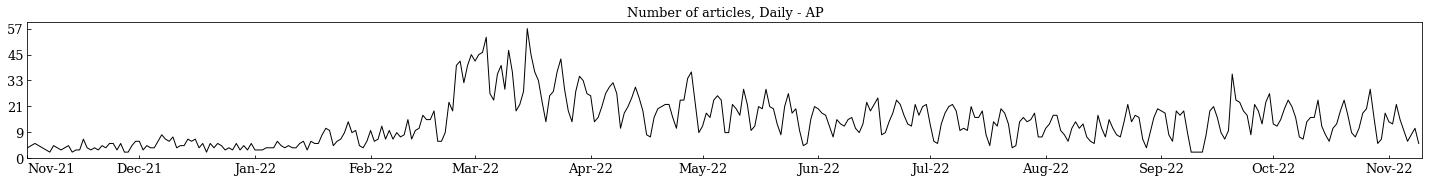

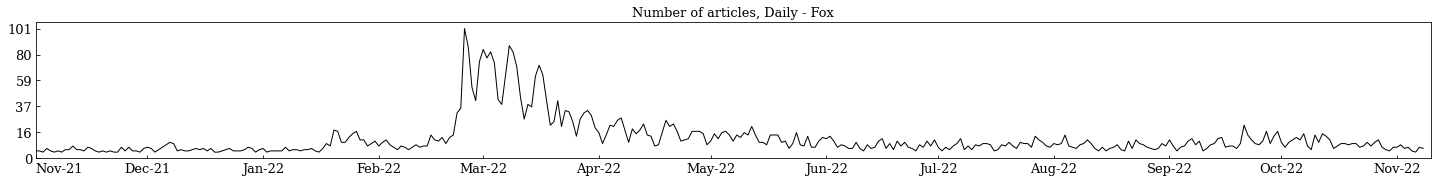

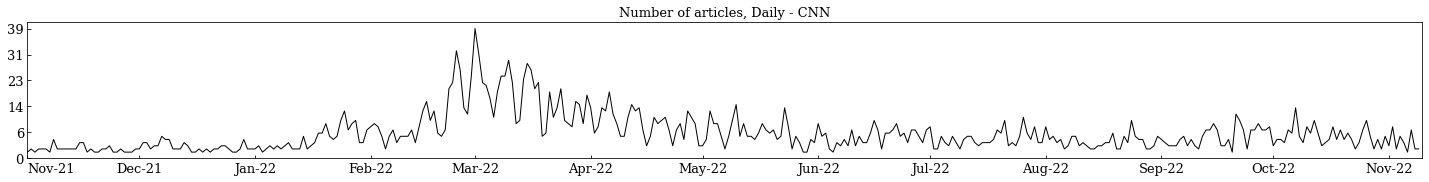

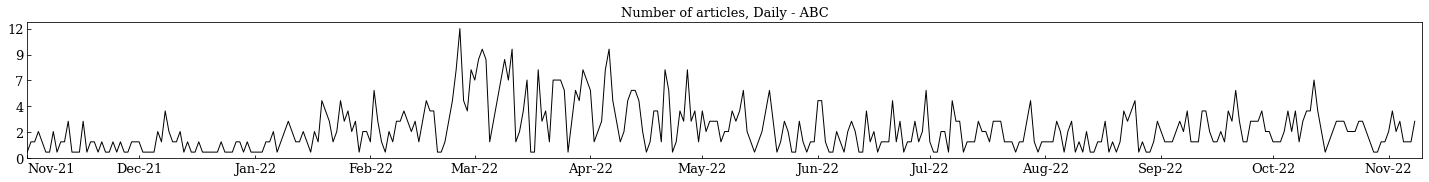

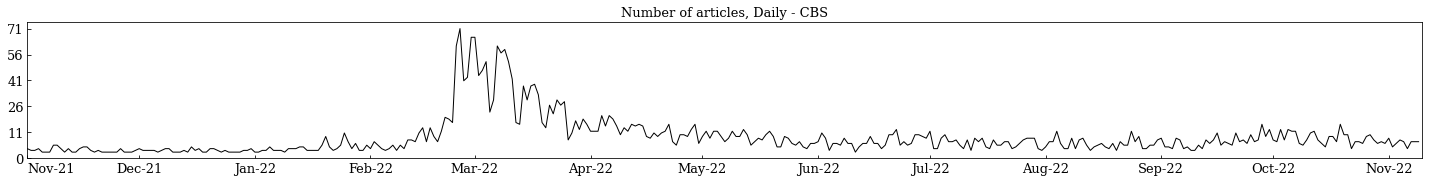

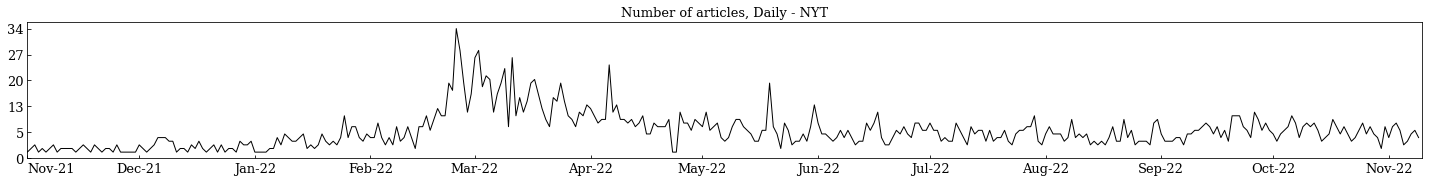

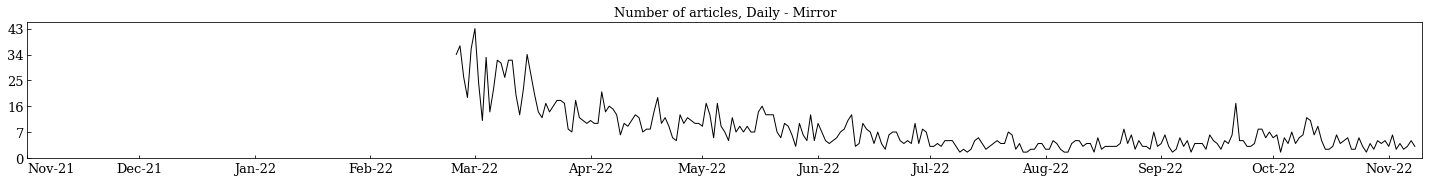

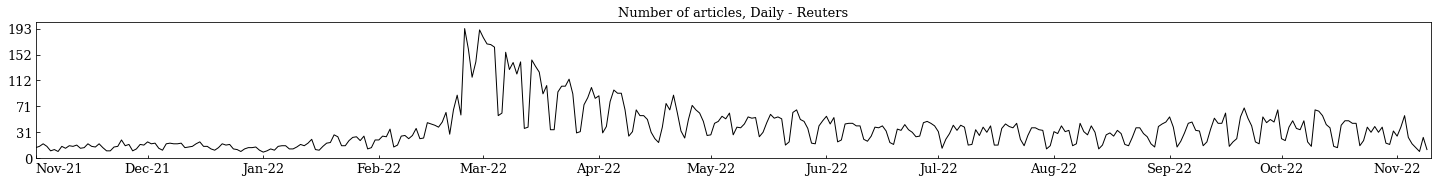

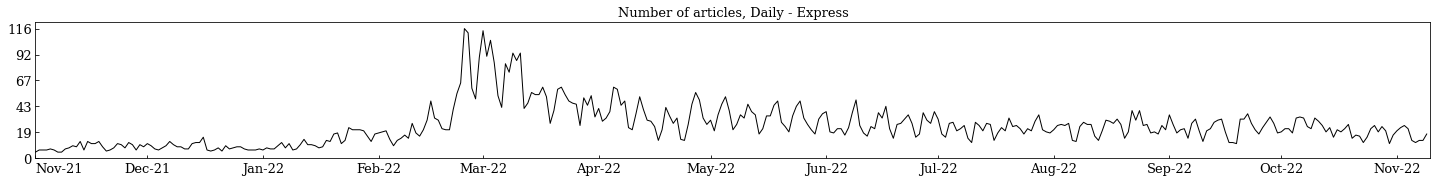

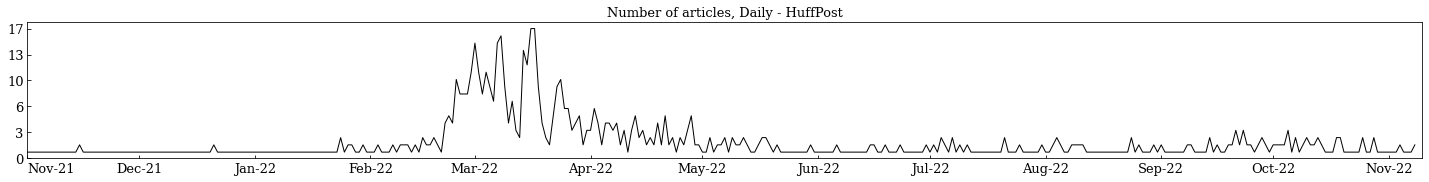

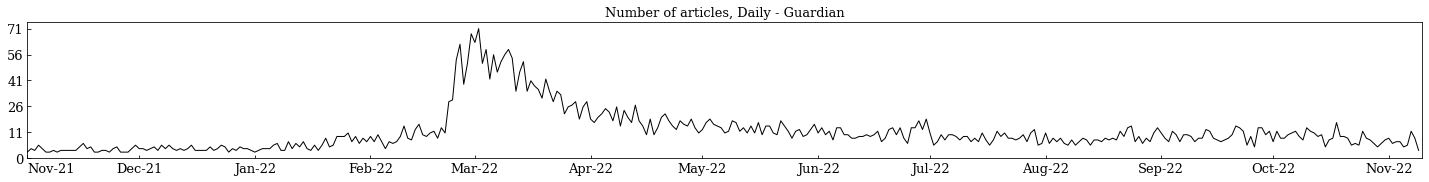

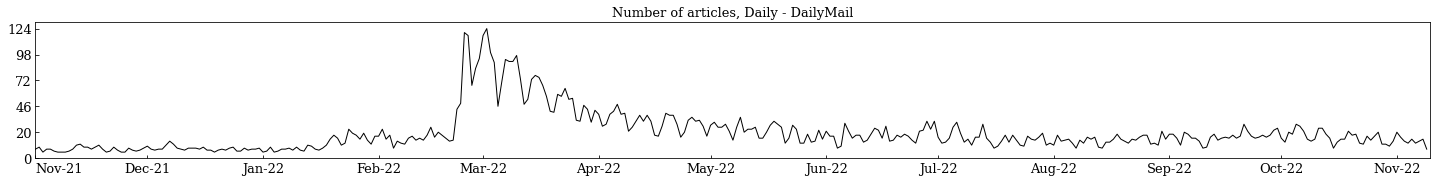

In [12]:
for i in range(0, len(source)):
    line_plot_count(dcount[i], f"Number of articles, Daily - {source[i]}")


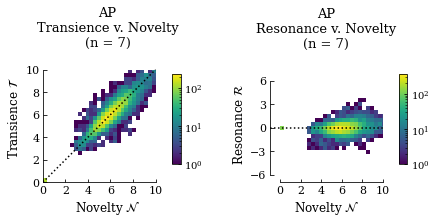

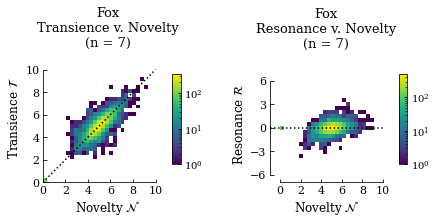

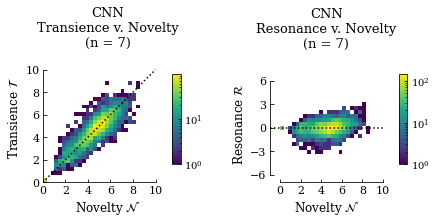

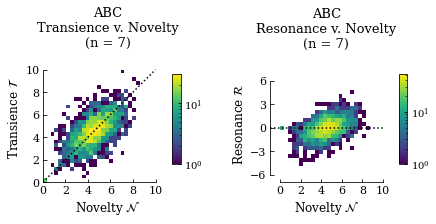

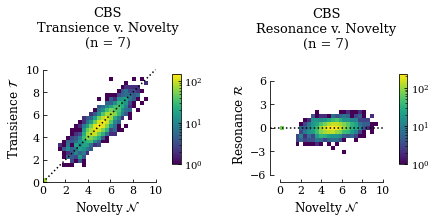

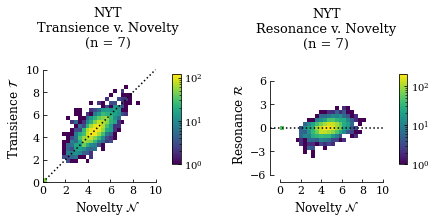

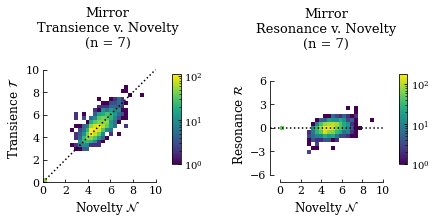

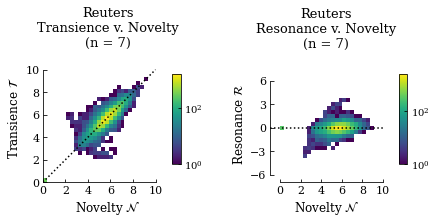

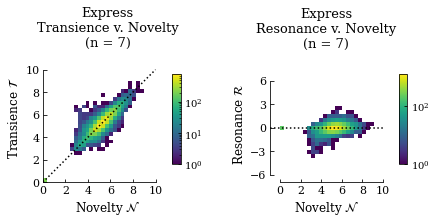

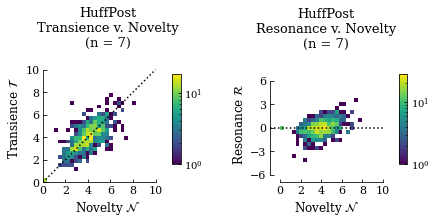

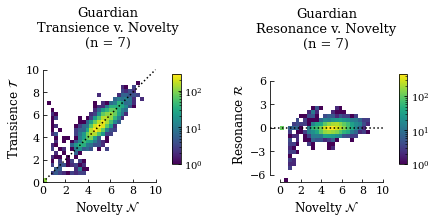

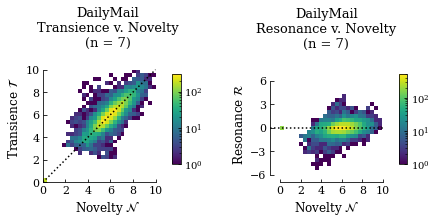

In [13]:
for name, data in zip(source, ntr):
    fig = tvn_plot(data, name, 7)
    fig.savefig(os.path.join(ROOT_DIR, "figures", name + "_TvN.svg"), format="svg", dpi=1000, bbox_inches="tight")


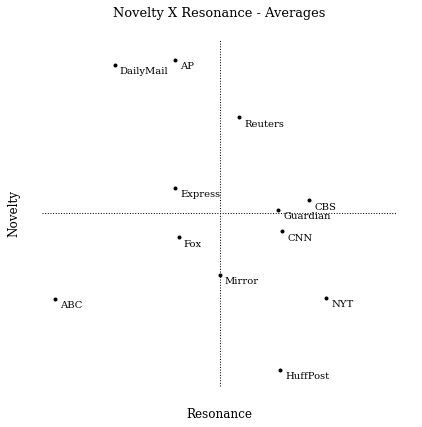

In [14]:
fig = scatter_resonance(dirs,'2021-02-01','2022-11-01')
fig.savefig(os.path.join(ROOT_DIR, "figures", name + "_Scatter_NvR.svg"), format="svg", dpi=1000, bbox_inches="tight")

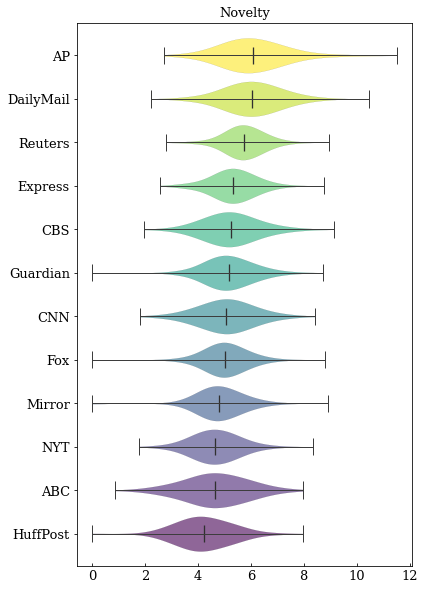

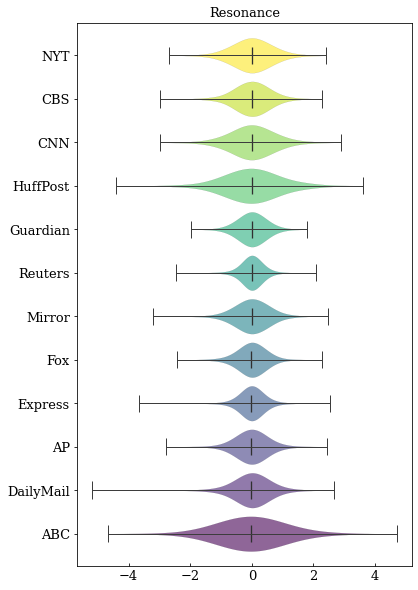

In [84]:
fig1 = violin("viridis","Novelty",dirs,'2021-02-01','2022-11-01')
fig1.savefig(os.path.join(ROOT_DIR, "figures", "Resonances_Violin.svg"), format="svg", dpi=1000, bbox_inches="tight")

fig2 = violin("viridis","Resonance",dirs,'2021-02-01','2022-11-01')
fig2.savefig(os.path.join(ROOT_DIR, "figures", "Resonances_Violin.svg"), format="svg", dpi=1000, bbox_inches="tight")